# Библиотеки, доступ

In [ ]:
# @title Библиотеки

import pandas as pd
import scipy as sc
import numpy as np
import scipy.stats as stats
from scipy.stats import shapiro, kstest, ttest_ind, norm, mannwhitneyu, binom
import math
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.stats.proportion as proportion
import matplotlib.pyplot as plt
import statsmodels.stats.power as smp
from tqdm.auto import tqdm
from random import randint
import seaborn as sns
from itertools import product
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pal = [
    "#be0707",
    "#dc3248",
    "#ef5a80",
    "#f982b2",
    "#fca9dd",
    "#ffcfff",
    "#eebdfb",
    "#daacf9",
    "#c19cf8",
    "#a48ef7",
    "#7e82f7",
]

sns.set_theme(style="white", palette=pal, rc={"figure.figsize": (6, 4)})

In [2]:
# @title Доступ в BQ

from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table
from google.cloud import bigquery
from google.oauth2 import service_account

project = "analytics-147612"  # Project ID inserted based on the query results selected to explore
location = "EU"  # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

ModuleNotFoundError: No module named 'google'

In [ ]:
# @title BQ - исторические данные только по юзерам из теста
sql = """
select
  ag.*
  ,birthdate
  ,country
  ,trading_account_created_date
  ,server_name
  ,ts.trading_account_type
  ,trading_account_platform
  ,ts.leverage
  ,ts.trading_product
  ,ts.account_number
  ,is_bonus
  ,is_contest
  ,is_created_from_signup
  ,device_type
  ,app
  ,platform
  ,event_time_dt as trading_start_dt
  ,volume
  ,

from wh_raw.ab_account_group ag
left join wh_raw.users_raw ur on ur.user_id = ag.user_id
left join amplitude.events_octa_raw_trading_accounts ta on ta.user_id = ag.user_id
left join amplitude.events_octa_raw_trading_started ts on ts.user_id = ag.user_id
where period_id = 46
  and trading_account_created_date > '2022-11-01'
  and ta.account_number = 1


"""

df = client.query(sql).to_dataframe()
df.head()

,id,period_id,user_id,client_id,random_value,current_group,history,created_at,birthdate,country,...,trading_product,account_number,is_bonus,is_contest,is_created_from_signup,device_type,app,platform,trading_start_dt,volume
0,9085296,46,28056184,<NA>,96,1,"{""46"":1}",2022-11-08 13:26:07,2004-05-05,Malaysia,...,trading,8,no,no,undefined,mobile,browser,web,2023-05-22 08:57:29+00:00,0.01
1,8930430,46,27924311,<NA>,7,0,"{""46"":0}",2022-11-01 15:36:53,2004-11-01,India,...,None,<NA>,no,no,undefined,None,None,web,NaT,NaN
2,9479632,46,28397638,<NA>,95,1,"{""46"":1}",2022-11-27 06:52:33,1999-01-04,Nigeria,...,None,<NA>,no,no,undefined,mobile,browser,web,NaT,NaN
3,9669544,46,25365316,<NA>,7,1,"{""46"":1}",2022-12-08 09:39:00,1992-11-01,Nigeria,...,trading,2,no,no,undefined,mobile,general app,android,2023-04-11 09:58:49+00:00,0.02
4,9819464,46,28868281,<NA>,62,1,"{""46"":1}",2022-12-17 23:41:12,1997-11-09,Malaysia,...,None,<NA>,no,no,undefined,mobile,general app,android,NaT,NaN


In [ ]:
# @title BQ - исторические данные

all_users_sql = """
select
  ta.user_id
  ,birthdate
  ,country
  ,trading_account_created_date
  ,server_name
  ,ts.trading_account_type
  ,trading_account_platform
  ,ts.leverage
  ,ts.trading_product
  ,ts.account_number
  ,is_bonus
  ,is_contest
  ,is_created_from_signup
  ,device_type
  ,app
  ,platform
  ,event_time_dt as trading_start_dt
  ,volume


from amplitude.events_octa_raw_trading_accounts ta
left join amplitude.events_octa_raw_trading_started ts on ts.user_id = ta.user_id
left join wh_raw.users_raw ur on ur.user_id = ta.user_id
where 1=1
  and trading_account_created_date > '2022-05-01'
  and ta.account_number = 1

"""
all_df = client.query(all_users_sql).to_dataframe()
all_df.head()

,user_id,birthdate,country,trading_account_created_date,server_name,trading_account_type,trading_account_platform,leverage,trading_product,account_number,is_bonus,is_contest,is_created_from_signup,device_type,app,platform,trading_start_dt,volume
0,11246915,1999-02-17,India,2023-08-22 17:14:23+00:00,demo,None,mt4,<NA>,None,<NA>,no,no,no,mobile,general app,android,NaT,NaN
1,34459571,None,India,2023-08-23 11:16:03+00:00,real,None,octa-trader,<NA>,None,<NA>,no,no,no,mobile,general app,android,NaT,NaN
2,34216010,2005-05-14,India,2023-08-22 11:53:56+00:00,demo,None,mt5,<NA>,None,<NA>,no,no,no,mobile,general app,android,NaT,NaN
3,34455148,None,India,2023-08-23 08:38:10+00:00,demo,None,octa-trader,<NA>,None,<NA>,no,no,no,mobile,general app,android,NaT,NaN
4,29923669,2004-11-01,India,2023-08-22 03:25:41+00:00,real,None,octa-trader,<NA>,None,<NA>,no,no,no,mobile,general app,android,NaT,NaN


# Работа с данными

* исследование метрик (чувствительность, окно, сезонность)
* проверка распределений статистик на нормальность
* работа с выбросами
* А/А тест

##  Исследование метрик
 * историческое поведение
 * окно
 * сезонность
 * чувствительность


### Историческое поведение метрики

In [ ]:
# @title пример
from datetime import datetime, timedelta

# генерим данные
start_date = pd.to_datetime("2022-08-01")
end_date = pd.to_datetime("2023-08-01")
months = pd.date_range(start=start_date, end=end_date, freq="MS").strftime("%Y-%m")

np.random.seed(42)
n_samples = len(months)
revenue = np.random.normal(100, 10, n_samples) + np.random.exponential(40, n_samples)
data_example = pd.DataFrame({"Revenue": revenue, "month": months})

sns.lineplot(data=data_example, y="Revenue", x="month", color=pal[9])
mean_value = data_example["Revenue"].mean()
std_value = data_example["Revenue"].std()


# Выделение области в пределах 3, 2, 1 сигм от среднего значения
plt.fill_between(
    data_example["month"],
    mean_value - 3 * std_value,
    mean_value + 3 * std_value,
    color=pal[5],
    alpha=0.3,
    label="3 Sigmas",
)
plt.fill_between(
    data_example["month"],
    mean_value - 2 * std_value,
    mean_value + 2 * std_value,
    color=pal[6],
    alpha=0.3,
    label="2 Sigmas",
)
plt.fill_between(
    data_example["month"],
    mean_value - 1 * std_value,
    mean_value + 1 * std_value,
    color=pal[7],
    alpha=0.3,
    label="1 Sigma",
)


plt.xlabel("")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

print(data_example)

In [ ]:
data = df

In [ ]:
ab_users_df = df

In [ ]:
all_df["ta_created_day"] = all_df["trading_account_created_date"].dt.strftime(
    "%Y-%m-%d"
)
all_df["ts_day"] = all_df["trading_start_dt"].dt.strftime("%Y-%m-%d")
all_df["is_account_created"] = (
    all_df["trading_account_created_date"].notnull().astype(int)
)
all_df["is_trading_started"] = all_df["trading_start_dt"].notnull().astype(int)

all_df["ta_created_month"] = all_df["trading_account_created_date"].dt.strftime("%Y-%m")
all_df["ts_month"] = all_df["trading_start_dt"].dt.strftime("%Y-%m")

In [ ]:
pivot = all_df.pivot_table(
    index=["ta_created_month"],
    values=["is_account_created", "is_trading_started"],
    aggfunc="sum",
).reset_index()
pivot

,ta_created_month,is_account_created,is_trading_started
0,2022-05,889020,64850
1,2022-06,741277,58412
2,2022-07,732126,58616
3,2022-08,756915,52138
4,2022-09,569040,39797
5,2022-10,559165,38966
6,2022-11,469937,36864
7,2022-12,604211,37343
8,2023-01,458672,40695
9,2023-02,509933,39307


In [ ]:
# отделить Индию в отдельный датафрейм
india_df = all_df[all_df["country"] == "India"]
other_df = all_df[all_df["country"] != "India"]

In [ ]:
pivot_india = india_df.pivot_table(
    index=["ta_created_month"],
    values=["is_account_created", "is_trading_started"],
    aggfunc="sum",
).reset_index()
pivot_india

,ta_created_month,is_account_created,is_trading_started
0,2022-05,411663,25883
1,2022-06,292542,18737
2,2022-07,306093,20794
3,2022-08,357956,21014
4,2022-09,238675,14809
5,2022-10,206802,12972
6,2022-11,136859,13338
7,2022-12,227757,14228
8,2023-01,95644,11703
9,2023-02,99066,11585


In [ ]:
# Индия ratio

pivot_india["trading_started_ratio"] = (
    pivot_india["is_trading_started"] / pivot_india["is_account_created"]
)
pivot_india

,ta_created_month,is_account_created,is_trading_started,trading_started_ratio
0,2022-05,411663,25883,0.062874
1,2022-06,292542,18737,0.064049
2,2022-07,306093,20794,0.067934
3,2022-08,357956,21014,0.058706
4,2022-09,238675,14809,0.062047
5,2022-10,206802,12972,0.062727
6,2022-11,136859,13338,0.097458
7,2022-12,227757,14228,0.062470
8,2023-01,95644,11703,0.122360
9,2023-02,99066,11585,0.116942


In [ ]:
# Остальные страны

pivot_other = other_df.pivot_table(
    index=["ta_created_month"],
    values=["is_account_created", "is_trading_started"],
    aggfunc="sum",
).reset_index()

pivot_other["trading_started_ratio"] = (
    pivot_other["is_trading_started"] / pivot_other["is_account_created"]
)

In [ ]:
pivot_other

,ta_created_month,is_account_created,is_trading_started,trading_started_ratio
0,2022-05,477357,38967,0.081631
1,2022-06,448735,39675,0.088415
2,2022-07,426033,37822,0.088777
3,2022-08,398959,31124,0.078013
4,2022-09,330365,24988,0.075638
5,2022-10,352363,25994,0.073771
6,2022-11,333078,23526,0.070632
7,2022-12,376454,23115,0.061402
8,2023-01,363028,28992,0.079862
9,2023-02,410867,27722,0.067472


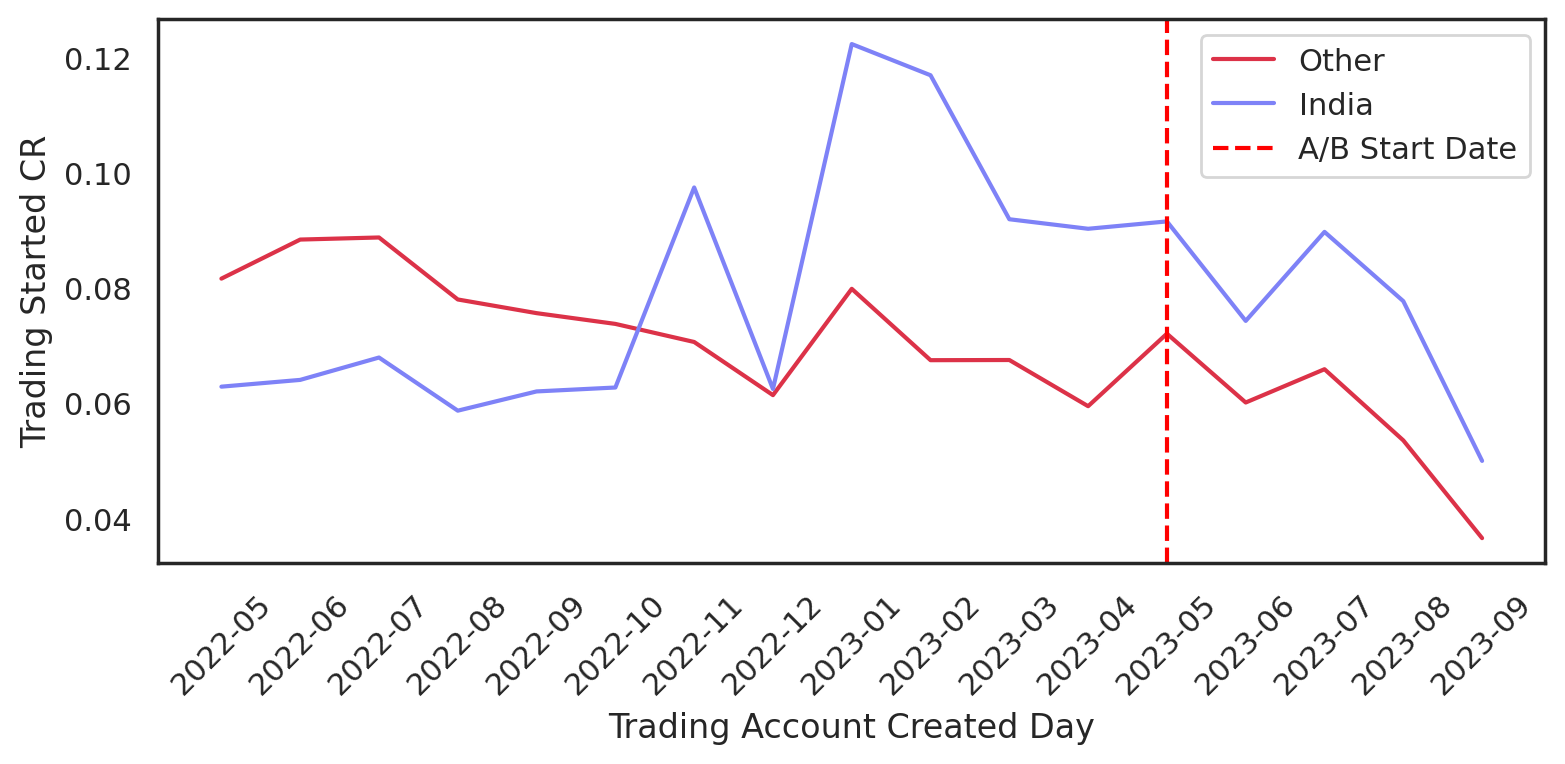

In [ ]:
ab_start_date = "2023-05"  # точная дата старта 2023-05-29

plt.figure(figsize=(8, 4))

sns.lineplot(
    data=pivot_other,
    x="ta_created_month",
    y="trading_started_ratio",
    label="Other",
    color=pal[1],
    legend="auto",
)
sns.lineplot(
    data=pivot_india,
    x="ta_created_month",
    y="trading_started_ratio",
    label="India",
    color=pal[10],
    legend="auto",
)

plt.axvline(x=ab_start_date, color="red", linestyle="--", label="A/B Start Date")

plt.xlabel("Trading Account Created Day")
plt.ylabel("Trading Started CR")
# plt.title('Trading Started Ratio')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#  кумулятивный CR
ind_test = pivot_india
ind_test.sort_values(by="ta_created_month", inplace=True)
ind_test["CR_cum"] = (
    ind_test["is_trading_started"].cumsum() / ind_test["is_account_created"].cumsum()
)
ind_test["ao_cum"] = ind_test["is_account_created"].cumsum()

ind_test

,ta_created_month,is_account_created,is_trading_started,trading_started_ratio,CR_cum,ao_cum
0,2022-05,411663,25883,0.062874,0.062874,411663
1,2022-06,292542,18737,0.064049,0.063362,704205
2,2022-07,306093,20794,0.067934,0.064747,1010298
3,2022-08,357956,21014,0.058706,0.063167,1368254
4,2022-09,238675,14809,0.062047,0.063000,1606929
5,2022-10,206802,12972,0.062727,0.062969,1813731
6,2022-11,136859,13338,0.097458,0.065389,1950590
7,2022-12,227757,14228,0.062470,0.065084,2178347
8,2023-01,95644,11703,0.122360,0.067493,2273991
9,2023-02,99066,11585,0.116942,0.069557,2373057


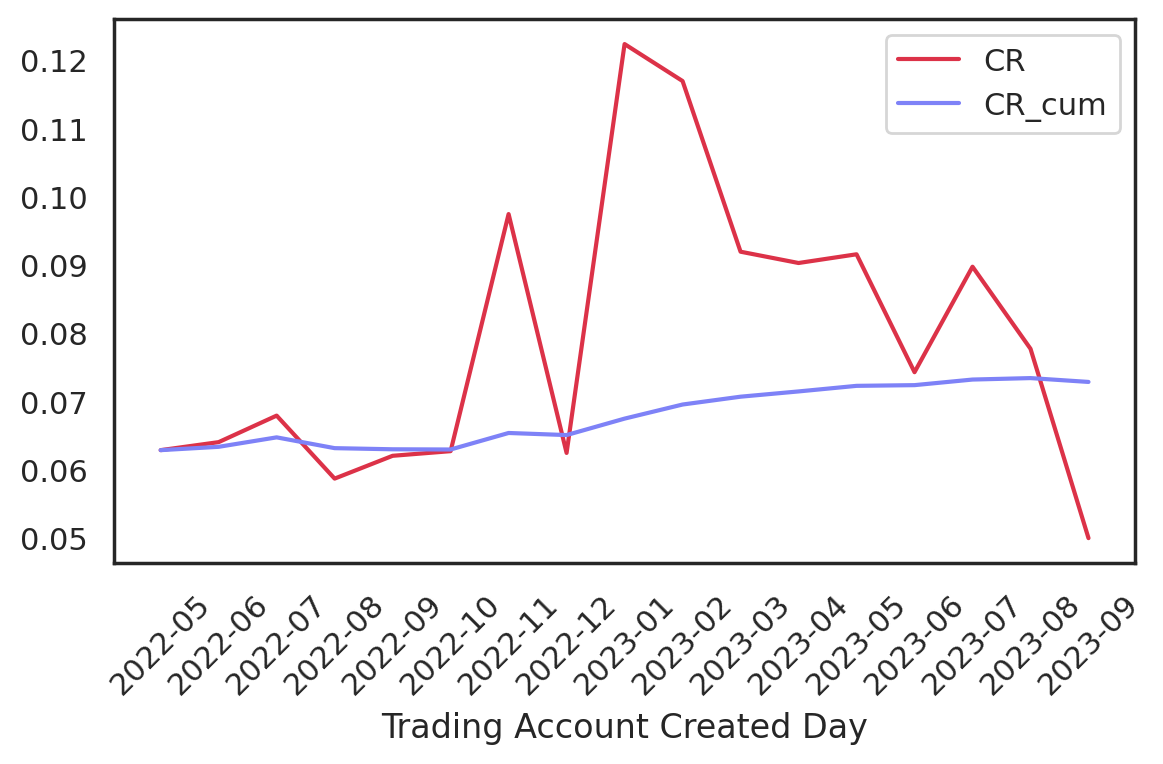

In [ ]:
# Индия CR & CR cum

sns.lineplot(
    data=ind_test,
    x="ta_created_month",
    y="trading_started_ratio",
    label="CR",
    color=pal[1],
    legend="auto",
)
sns.lineplot(
    data=ind_test,
    x="ta_created_month",
    y="CR_cum",
    label="CR_cum",
    color=pal[10],
    legend="auto",
)
plt.xlabel("Trading Account Created Day")
plt.ylabel("")
# plt.title('Trading Started Ratio & Cumulative')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

### Чувствительность

In [4]:
# @title пример


# Сгенерированные данные. Нужно загрузить данные за продолжительный
# исторический период. Это необходимо, чтобы учесть поведение пользователя и распределение
# оригинальной метрики

np.random.seed(1)
mu = 42.0
sd = 10.0
data = norm.rvs(loc=mu, scale=sd, size=10000)
alpha = 0.05  # 1 - уровень значимости
simulations = 1000  # количество симуляций
lifts = np.arange(1, 1.1, 0.02)  # последовательность шагов по эффекту

# Последовательность шагов по увеличению выборки.
# Чтобы учесть окно метрики, лучше брать даты в качестве шага
sizes = np.arange(1000, 4001, 1000)

sim_res = pd.DataFrame()

for lift, n in product(lifts, sizes):
    print(lift, n)

    control = data[0:n]

    # равномерно распределяем эффект по всему распределению
    test = control * lift

    for _ in tqdm(range(0, simulations)):
        # Рандомное присвоение групп A/B
        is_control = binom.rvs(1, 0.5, size=n)

        # Считаем p-value
        _, p = mannwhitneyu(control[is_control == True], test[is_control == False])

        # Кладем результат
        sim_res = pd.concat(
            [
                pd.DataFrame({"lift": lift, "n": n, "pvalue": p}, index=[len(sim_res)]),
                sim_res,
            ],
            ignore_index=True,
        )


def calculate_tpr(df, sim_num):
    names = {"tpr": sum(df["pvalue"] < 0.05) / sim_num}
    return pd.Series(names)


res = (
    sim_res.groupby(["lift", "n"])
    .apply(calculate_tpr, sim_num=simulations)
    .reset_index()
)

1.0 1000


100%|██████████| 1000/1000 [00:00<00:00, 1079.53it/s]


1.0 2000


100%|██████████| 1000/1000 [00:01<00:00, 760.99it/s]


1.0 3000


100%|██████████| 1000/1000 [00:01<00:00, 549.32it/s]


1.0 4000


100%|██████████| 1000/1000 [00:02<00:00, 442.93it/s]


1.02 1000


100%|██████████| 1000/1000 [00:00<00:00, 1111.79it/s]


1.02 2000


100%|██████████| 1000/1000 [00:01<00:00, 756.06it/s]


1.02 3000


100%|██████████| 1000/1000 [00:01<00:00, 532.84it/s]


1.02 4000


100%|██████████| 1000/1000 [00:02<00:00, 444.49it/s]


1.04 1000


100%|██████████| 1000/1000 [00:00<00:00, 1131.26it/s]


1.04 2000


100%|██████████| 1000/1000 [00:01<00:00, 739.05it/s]


1.04 3000


100%|██████████| 1000/1000 [00:01<00:00, 535.01it/s]


1.04 4000


100%|██████████| 1000/1000 [00:02<00:00, 438.47it/s]


1.06 1000


100%|██████████| 1000/1000 [00:00<00:00, 1144.83it/s]


1.06 2000


100%|██████████| 1000/1000 [00:01<00:00, 772.00it/s]


1.06 3000


100%|██████████| 1000/1000 [00:01<00:00, 573.78it/s]


1.06 4000


100%|██████████| 1000/1000 [00:02<00:00, 451.92it/s]


1.08 1000


100%|██████████| 1000/1000 [00:00<00:00, 1108.53it/s]


1.08 2000


100%|██████████| 1000/1000 [00:01<00:00, 722.92it/s]


1.08 3000


100%|██████████| 1000/1000 [00:01<00:00, 548.77it/s]


1.08 4000


100%|██████████| 1000/1000 [00:02<00:00, 446.20it/s]


1.1 1000


100%|██████████| 1000/1000 [00:00<00:00, 1145.13it/s]


1.1 2000


100%|██████████| 1000/1000 [00:01<00:00, 763.02it/s]


1.1 3000


100%|██████████| 1000/1000 [00:01<00:00, 566.67it/s]


1.1 4000


100%|██████████| 1000/1000 [00:02<00:00, 433.50it/s]


In [5]:
sim_res

,lift,n,pvalue
0,1.1,4000,1.860939e-34
1,1.1,4000,5.050242e-37
2,1.1,4000,1.795470e-39
3,1.1,4000,2.220387e-38
4,1.1,4000,3.622519e-31
...,...,...,...
23995,1.0,1000,7.005394e-02
23996,1.0,1000,9.820875e-01
23997,1.0,1000,5.391957e-01
23998,1.0,1000,4.693020e-01


In [ ]:
display(res)
sns.lineplot(data=res, x="n", y="tpr", hue="lift")

## Проверка распределений статистик на нормальность

* гистограмма
* qq - график
* тест Шапиро
* тест Колмогорова-Смирнова

In [ ]:
# @title Гистограмма и  qq-график

# генерим данные
n = 10000  # Размер выборки
scale = 50  # Параметр масштаба для экспоненциального распределения
noise_scale = 10  # Масштаб шума
data = np.random.exponential(scale=scale, size=n) + np.random.normal(
    scale=noise_scale, size=n
)

mean = np.mean(data)
std = np.var(data)

print("mean:", mean)
print("std:", std)
plt.hist(data, bins=100, density=True, alpha=0.7, color=pal[9])
plt.title("Распределение данных")
plt.show()

# выборочные средние
sample_size = 50
num_samples = 1000

sample_means = []
for i in range(num_samples):
    sample = np.random.choice(data, size=sample_size, replace=False)
    sample_mean = np.mean(sample)
    sample_means.append(sample_mean)

i, p_value = shapiro(sample_means)
plt.hist(sample_means, bins=50, density=True, alpha=0.7, color=pal[9])
plt.xlabel("Выборочное среднее")
plt.ylabel("Плотность вероятности")
plt.title("Распределение выборочных средних")
plt.show()

# квантиль-квантильный график
sm.qqplot(
    np.array(sample_means), line="s", markerfacecolor=pal[9], markeredgecolor=pal[1]
)
plt.title("Q-Q Plot")
plt.xlabel("Теоретические квантили")
plt.ylabel("Выборочные квантили")
plt.show()

### Тест Шапиро

Проверяет гипотезу о нормальности распределения выборки:

$H_0$: выборка взята из генеральной совокупности с нормальным распределением

$H_1$: выборка взята из генеральной совокупности с другим распределением

In [ ]:
i, p_value = shapiro(sample_means)

if p_value > 0.05:
    print("Выборочные средние распределены нормально, p-value = ", p_value)
else:
    print("Выборочные средние не распределены нормально, p-value = ", p_value)

### Тест Колмогорова-Смирнова

Проверяет гипотезу о принадлежности выборки некоторому известному распределению. То есть можно проверять не только принадлежность нормальному, но и t-распределению, биномиальному, логнормальному и т д

In [ ]:
i, p_value = kstest(sample_means, "norm")

if p_value > 0.05:
    print("Выборочные средние распределены нормально, p-value = ", p_value)
else:
    print("Выборочные средние не распределены нормально, p-value = ", p_value)

## Выбросы

## А/А тест

# Дизайн

 * формилировка гипотезы
 * выбор метрик, сегментов, статкритерия,
 * рассчет длительности


#### Рекомендации по дизайну АБ:



* [Гипотеза и стоимость разработки](https://octafx.atlassian.net/wiki/spaces/AN/pages/3187933247)

* [Выбор метрик](https://octafx.atlassian.net/wiki/spaces/AN/pages/3188162595)

* [Данные, с которыми работаем](https://octafx.atlassian.net/wiki/spaces/AN/pages/3188195359)

* [Сегменты и сплиттинг](https://octafx.atlassian.net/wiki/spaces/AN/pages/3187802345)

* [Размер эффекта, выборки, длина теста](https://octafx.atlassian.net/wiki/spaces/AN/pages/3187376199/1+2)

* [Выбор стат критерия](https://octafx.atlassian.net/wiki/spaces/AN/pages/3188129851)

## Гипотеза, метрики

**Гипотеза**: Конверсия из создания аккаунта в сделку не будет значимо отличаться в контрольной и тестовой группах


**Что делаем**: Мы поместим карточку OctaTrader в визарде на первое место (recommended) для 3% аудитории (в Индии 6%)

**Почему необходимо проводить АБ. Оценка стоимости:** Хотим проверить можем ли мы безопасно для бизнеса (не ухудшая конверсию) масштабировать присуствие платформы OctaTrader

**Целевая метрика:** CR Created Account - First Trade

**Доп метрики:** CR Registration - Created Account; балланс веток (SRM)

**Сегмент:** зарегистрированные, все кто проходит через визард, все страны

**Сплит:** 94/6 через msAB, для тех, кому доступно OTR (6% Ind, 3% все остальные)

---

**Стат критерий:** z-тест

**Уровень значимости:** 95%

**Мощность:** 80%

**MDE:** 1%

**Длительность:** 30 дней + окно ?


## Выбор статкритерия


Выбор статкритерия зависит от сформулированной гипотезы, выбранной метрики и данных. Глобально можно выделить 2 типа критериев: параметрические (t-тест, z-тест и др.) и непараметрические (U-тест и др.). Параметрические основаны на наших предположениях о распределении данных (оно известно) в отличие от непараметрических.


---


Для разных типов метрик подходят разные стат тесты. Основные из них такие:

1) Средние метрики пользователя (средний депозит, средний объем, среднее количество сделок). Чаще всего наиболее полходящий вариант использовать t-тест с модификацией Уэлша, если единица рандомизации в тесте - юзер, нет больших выбросов и выборочное среднне распределено нормально (об этом ниже). Если единица рандомизации теста не совпадает со знаменателем (например, тест рандомизирован по юзерам, а метрика -- число сделок за сессию), то лучше использовать дельта метод.

2) Конверсии пользователей (конверсия из регистрации в активацию, конверсия в начало торговли, N-day ретеншен). Подходит Z-тест


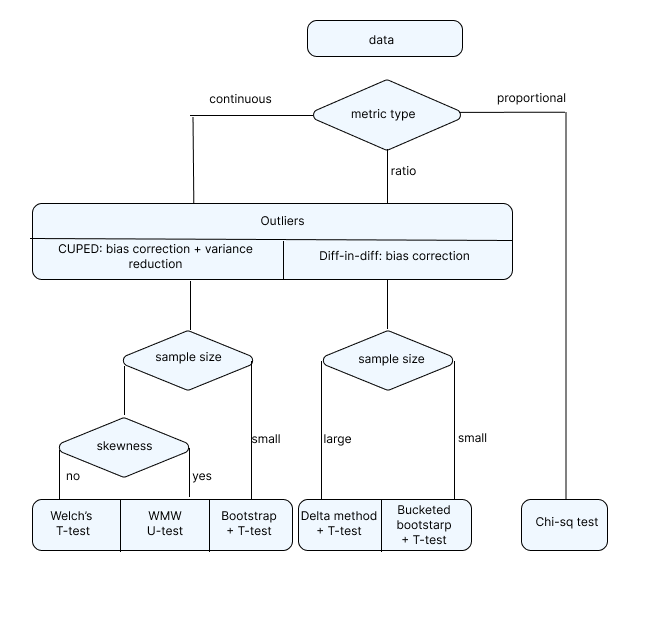

#### **Критерий Стьюдента (t-тест)**




Проверяет гипотезу о равенстве средних.

$H_o : \mu_1 = \mu_2$

$H_1 : \mu_1 \neq \mu_2$

 Не требует нормального распределения данных, но требует нормального распределения выборочных средних, что в большинстве случаев и получается, если наблюдения независимы и одинаково распределены ([ЦПТ](https://en.wikipedia.org/wiki/Central_limit_theorem)).

 Проверить распределение выборочных средних на нормальность можно тестом Шапиро, Колмогорова-Смирнова; также можно визуально оценить само распределение и qq-график c нормальным (! но это будет лишь визуальная оценка!) -- *см в пункте Данные с которыми работаем*

Важно: чувствителен к выбросам, не подходит для долей и ratio-метрик

In [ ]:
# пример как работает

#### **Критерий долей (Z-тест)**

Работают с распределениями Бернулли. Они принимают на вход выборки из нулей и единиц и проверяют гипотезы о параметрах p этих распределений (вероятность появления единицы в выборке).

z-тест пропорций работает по тому же принципу, что t-тест для непрерывных величин:

$$z = \frac{разница \ долей}{стандартная \  ошибка} = \frac{p_1 - p_2}{\sqrt{(\frac{p_1(1-p_1)}{n_1} + \frac{p_2(1-p_2)}{n_2}}}$$

$p_1, p_2$ -- доли в 1й и 2й выборках

In [ ]:
# пример как работает

#### **Критерий Уилкоксона-Манна-Уитни (U-тест)**

Используется для сравнения распределений двух независимых выборок. Применяется для непрерывных и дискретных данных. Чувствителен к выбросам.

Важно отметить, что он проверяет это с помощью сравнения ранговых сумм. Если ранги отличаются, значит присутствуют структурные изменения в распределениях

In [ ]:
# пример как работает

#### **Дельта-метод + T-тест**



Применяется для ratio метрик, в которых числитель и знаменатель могут иметь совместное распределение (нарушается требование о независимости и одинаковом распределении данных, которое необходимо для t-теста). Например, метрика $CTR = \frac{\text{клики}}{\text{просмотры}}$, единица рандомизации -- юзер. Один юзер может несколько раз просматривать, поэтому просмотры не будут независимыми случайными величинами.

Дельта-метод аппроксимирует дисперсию ratio метрики с помощью разложения в ряд Тейлора по первому члену.

Пусть есть фунция $y = f(x)$,  ее разложение в ряд Тейлора в точке $\mu_x$:

$$y=f(x)=f\left(\mu_x\right)+\left(X-\mu_x\right) f^{\prime}\left(\mu_x\right)+\frac{1}{2}\left(X-\mu_x\right)^2 f^{\prime \prime}\left(\mu_x\right)$$

Тогда дисперсия функции $y$ аппроксимируется:
 $$\operatorname{Var}(y) \approx f^{\prime}\left(\mu_x\right)^2 \sigma_x^2$$

 Применяем к ratio-метрике $R = \frac{y}{x}$:

 $$\operatorname{Var}\left(\frac{\bar{y}}{\bar{x}}\right) \approx \frac{1}{n} \frac{\mu_y^2}{\mu_x^2}\left[\frac{\sigma_y^2}{\mu_y^2}-2 \frac{\operatorname{Cov}(x, y)}{\mu_x \mu_y}+\frac{\sigma_x^2}{\mu_x^2}\right]$$

Далее находим t-значение ratio-метрики и вычисляем $p$-значение:
$$T=\frac{\mu_{\text {tr}}-\mu_{\text {c}}}{\sqrt{\sigma_{\text {tr}}^2 +\sigma_{\text {c}}^2 }} $$



In [ ]:
# на примере метрики CTR = клики/просмотры

click_control = [randint(0, 20) for i in range(10000)]
view_control = [randint(1, 60) for i in range(10000)]

click_treatment = [randint(0, 21) for i in range(10000)]
view_treatment = [randint(1, 60) for i in range(10000)]

control = pd.DataFrame({"click": click_control, "view": view_control})
treatment = pd.DataFrame({"click": click_treatment, "view": view_treatment})


# эстимируем дисперсию ratio метрики
def var_ratio(x, y):  # x/y
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    var_x = np.var(x, ddof=1)
    var_y = np.var(y, ddof=1)
    cov_xy = np.cov(x, y, ddof=1)[0][1]
    result = (
        (var_x / mean_x**2 + var_y / mean_y**2 - 2 * cov_xy / (mean_x * mean_y))
        * (mean_x**2)
        / (len(x) * mean_y**2)
    )
    return result


# ttest calculation
def ttest(mean_control, mean_treatment, var_control, var_treatment, alpha):
    diff = mean_treatment - mean_control
    var = var_control + var_treatment
    t_alpha = stats.t.ppf(1 - alpha / 2, 10000)

    stde = t_alpha * np.sqrt(var)
    lower = diff - stde
    upper = diff + stde
    t = diff / np.sqrt(var)
    p_value = (1 - stats.norm.cdf(np.abs(t))) * 2
    result = {
        "mean_control": mean_control,
        "mean_treatment": mean_treatment,
        "var_control": var_control,
        "var_treatment": var_treatment,
        "difference": diff,
        "lower_bound": lower,
        "upper_bound": upper,
        "alpha": alpha,
        "p-value": p_value,
    }
    return pd.DataFrame(result, index=[0])


var_control = var_ratio(control["click"], control["view"])
var_treatment = var_ratio(treatment["click"], treatment["view"])
mean_control = control["click"].sum() / control["view"].sum()
mean_treatment = treatment["click"].sum() / treatment["view"].sum()

ttest(mean_control, mean_treatment, var_control, var_treatment, alpha)

,mean_control,mean_treatment,var_control,var_treatment,difference,lower_bound,upper_bound,alpha,p-value
0,0.326983,0.345352,0.000007,0.000008,0.018369,0.010632,0.026106,0.05,0.000003


In [ ]:
stats.norm.sf(abs(4.70068870217811)) * 2

2.5928552682658317e-06

#### **Бутстрап**


Используется для оценки параметров распределений: среднее, медиана, дисперсия, доверительные интервалы, квантили. Основная идея бутстрапа заключается в том, чтобы создать множество подвыборок (бутстрэп-выборок), размер которых равен исходному набору данных, путём случайной выборки элементов с возвращением из исходного набора данных.
Не требует предположений о распределении данных. Устойчив к выбросам.

Дает неверные оценки, если есть заметные зависимости в данных.

In [ ]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_0: list,  # числовые значения первой выборки
    data_1: list,  # числовые значения второй выборки
    boot_it: int = 1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    conf_level: float = 0.95,  # уровень значимости,
    ba: bool = False,  # флаг bias - коррекции
):
    boot_data = []
    for _ in tqdm(range(boot_it)):  # извлекаем подвыборки
        boot_0 = data_0.sample(len(data_0), replace=True).values
        boot_1 = data_1.sample(len(data_1), replace=True).values
        boot_data.append(
            statistic(boot_0) - statistic(boot_1)
        )  # mean() - применяем статистику

    # поправляем смещение
    if ba:
        orig_theta = statistic(data_0) - statistic(data_1)  # разница в исходных данных
        boot_theta = np.mean(
            boot_data
        )  # среднее по бутстрапированной разнице статистик
        delta_val = abs(orig_theta - boot_theta)  # дельта для сдвига
        boot_data = [
            i - delta_val for i in boot_data
        ]  # сдвигаем бут разницу статистик, обратите внимание, что тут не вычитание
        print(
            f"""
            До бутстрапа: {orig_theta},
            После бутстрапа: {boot_theta},
            После коррекции: {np.mean(boot_data)}"""
        )

    left_quant = (1 - conf_level) / 2
    right_quant = 1 - (1 - conf_level) / 2
    ci = pd.DataFrame(boot_data).quantile([left_quant, right_quant])

    # p-value
    p_1 = norm.cdf(x=0, loc=np.mean(boot_data), scale=np.std(boot_data))
    p_2 = norm.cdf(x=0, loc=-np.mean(boot_data), scale=np.std(boot_data))
    p_value = min(p_1, p_2) * 2

    # Визуализация
    plt.hist(pd.DataFrame(boot_data)[0], bins=50, color=pal[7])
    # plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle="--", colors=pal[1])
    plt.xlabel("boot_data")
    plt.ylabel("frequency")
    plt.title("Histogram of boot_data")
    plt.show()

    return {"boot_data": boot_data, "ci": ci, "p_value": p_value}

In [ ]:
# будем пробовать бутстрап на эксп. распределении
np.random.seed(5)

n = 1000
lift = 1.01

x = np.random.exponential(size=n)
y = np.random.exponential(size=n) * lift
print(np.mean(x) - np.mean(y))

df = pd.DataFrame({"x": x, "y": y})

-0.09879990025163365


  0%|          | 0/2000 [00:00<?, ?it/s]


            До бутстрапа: -0.06171236871031671,
            После бутстрапа: -0.05975448556642615,
            После коррекции: -0.06171236871031671


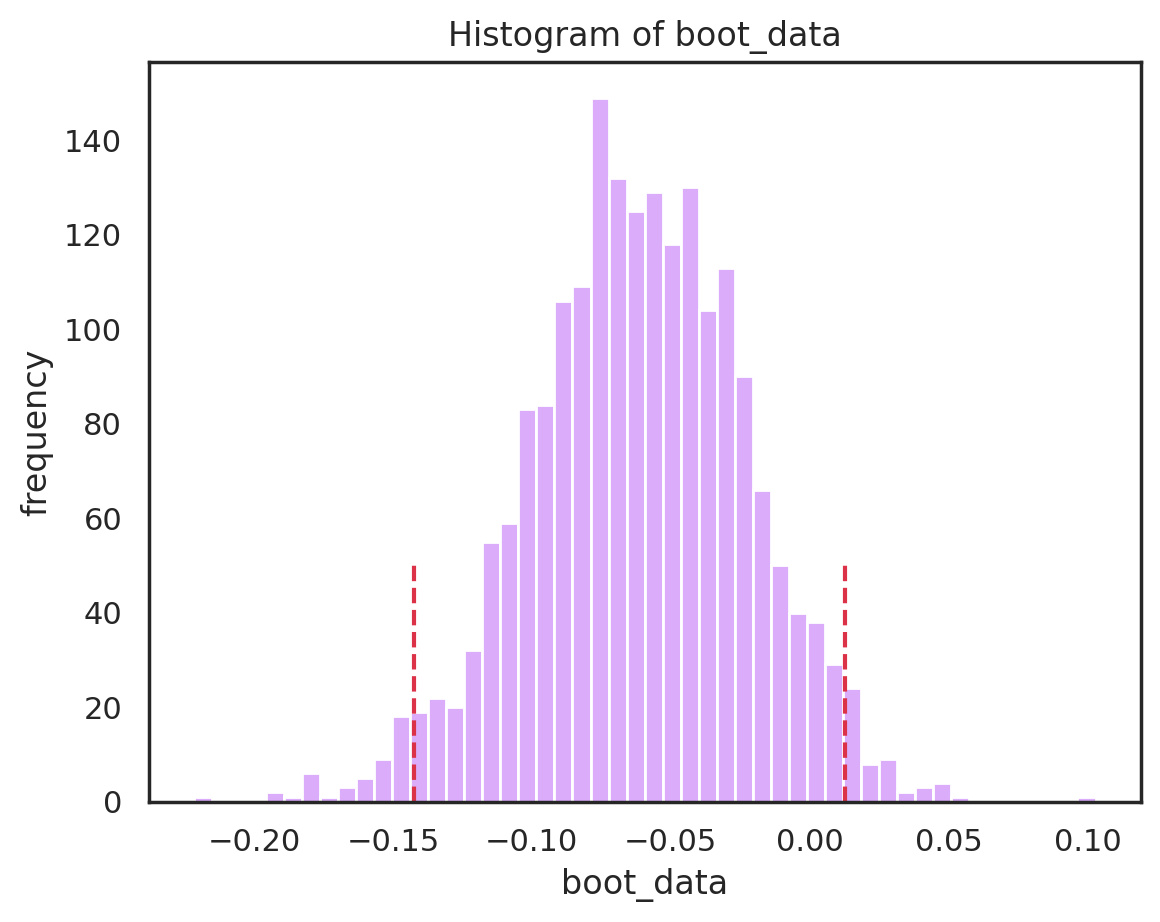

{'boot_data': [-0.04613061318073208, -0.03418137021665757, -0.07434205116125614, -0.03193791951066727, -0.07267497561469105, -0.06880536584696872, -0.06186514417530953, -0.06479097641762677, 0.02171039968221855, -0.12135190078482117, -0.06999351417399702, -0.058782785826472894, -0.014692043775493824, -0.11350220802531252, -0.07574384883077712, -0.08593477342614164, -0.05877822740838401, 0.0021693834383833543, -0.11153042433315397, -0.09227269946579031, -0.06139476223818663, -0.04079594751199489, -0.014217847537994155, -0.08471752943166544, -0.08415251193900863, -0.05461666888737793, -0.0838435812980326, 0.001604471741433522, -0.030014524925254915, -0.05105820235645331, -0.09409018384169021, -0.11536097472313755, -0.07583054847940218, -0.04974352259991155, -0.07950542742734079, -0.06378155336477909, -0.03124829086949621, -0.06486773553888736, -0.09243489874346811, -0.03038048510571889, -0.08751815892911041, -0.10206306267967746, -0.11678315257470784, -0.0649110484065687, -0.093406500359

In [ ]:
booted_data = get_bootstrap(
    df.x, df.y, statistic=lambda x: np.quantile(x, q=0.5), ba=True, boot_it=2000
)
# в результате хранится разница двух распределений, ДИ и pvalue
print(booted_data)

## Анализ размера эффекта, количества наблюдений, мощности

Хотим, чтобы выполнялись требования:

* Уровень значимости: >95%

* Мощность: >80%

* MDE: > 1%

* Длительность:  < 30 дней

#### **Как расчитать размер выборки**


* выбрать подходящий статкритерий, исходя из данных

* определить параметры: уровень значимости $\alpha$, мощность $1-\beta$, минимальный детектируемый эффект $MDE$

* вычислить Effect Size (SMD, Cohen's d) -- степень отклонения наблюдаемых значений от тех, которые можно было бы ожидать при отсутствии эффекта.
[wiki](https://en.wikipedia.org/wiki/Effect_size#Cohen's_d)

* Использовать формулу для рассчета размера выборки
  * для T-теста:  
  $$n=2\left(t_{\alpha / 2}+t_\beta\right)^2 \frac{\sigma^2}{\text {MDE}^2}$$
  * для Z-теста:
   $$n=2\left(z_{\alpha / 2}+z_\beta\right)^2 \frac{\frac{p_1(1-p_1)}{n_1} + \frac{p_2(1-p_2)}{n_2}}{\text{MDE}^2}$$




In [12]:
# @title Задаём параметры, трафик

alpha = 0.05
power = 0.8
lift = 1.7  # желаемый эффект
ratio = 1

day_traff = 60000  # юзеров проходят верификацию ежедневно
days = 5  # длительность теста
n = day_traff * days  # число наблюдений за время теста (обе ветки)
print("Сколько наблюдений будет, исходя из трафика (обе ветки):", n)

Сколько наблюдений будет, исходя из трафика (обе ветки): 300000


In [13]:
# @title Z-test

p_x = 0.015  # базовая конверсия
p_y = p_x * lift  # ожидаемая конверсия

# effect_size = 2*math.asin(np.sqrt(p_x)) - 2*math.asin(np.sqrt(p_y))
effect_size = sms.proportion_effectsize(p_y, p_x)
print("Effect size:", effect_size)

size = smp.zt_ind_solve_power(
    effect_size=effect_size, alpha=alpha, power=power, alternative="two-sided"
)
print("Сколько наблюдений необходимо (обе ветки):", math.ceil(2 * size))

power = smp.zt_ind_solve_power(
    effect_size=effect_size, nobs1=n / 2, alpha=alpha, alternative="two-sided"
)
print("Power:", power)

Effect size: 0.07518202817380809
Сколько наблюдений необходимо (обе ветки): 5555
Power: 1.0


In [ ]:
# @title T-test

mu_0 = 7.5  # среднее в контроле
mu_1 = mu_0 * lift  # среднее в тесте
std_0 = 3

effect_size = abs((mu_1 - mu_0) / std_0)
print("Effect size", effect_size)

# size = smp.tt_ind_solve_power(effect_size = effect_size, nobs1 = None, alpha = alpha, power = power, alternative='two-sided')
# print('Сколько наблюдений необходимо (обе ветки):', math.ceil(2*size))

size = smp.zt_ind_solve_power(
    effect_size=effect_size,
    nobs1=None,
    alpha=alpha,
    power=power,
    alternative="two-sided",
)
print("Size 1 sample:", size)

Effect size 0.125
Size 1 sample: 1004.6541460552606


In [ ]:
# @title Дельта метод (для ratio метрик)


def ratio_sample_size(
    num_mean, denom_mean, num_var, denom_var, cov, alpha, power, relative_mde
):
    tau = (
        (num_mean**2)
        / (denom_mean**2)
        * (
            num_var / (num_mean**2)
            + denom_var / (denom_mean**2)
            - 2 * cov / (num_mean * denom_mean)
        )
    )
    z_alpha = norm.ppf(1 - alpha / 2)
    z_power = norm.ppf(power)
    baseline_ratio = num_mean / denom_mean
    mde = baseline_ratio * lift - baseline_ratio
    expected_lift = mde / baseline_ratio
    n = math.ceil((2 * tau * (z_alpha + z_power) ** 2) / (mde**2))
    print("z_alpha:", z_alpha)
    print("z_power:", z_power)
    result = {
        "total_sample_size": n * 2,
        "each_variant_sample_size": n,
        "baseline_effect": baseline_ratio,
        "expected_lift": expected_lift,
        "power": power,
        "alpha": alpha,
    }
    return pd.DataFrame(result, index=[0])


num_mean = 12000
denom_mean = 100
num_var = 10
denom_var = 20
cov = 0.5  # ковариация числителя и знаменателя
lift = 1.01  # относительный прирост среднего к бэйзлайну

res = ratio_sample_size(
    num_mean=num_mean,
    denom_mean=denom_mean,
    num_var=num_var,
    denom_var=denom_var,
    cov=cov,
    alpha=alpha,
    power=power,
    relative_mde=lift,
)
res

z_alpha: 1.959963984540054
z_power: 0.8416212335729143


,total_sample_size,each_variant_sample_size,baseline_effect,expected_lift,power,alpha
0,628,314,120.0,0.01,0.8,0.05


# Анализ

проводится анализ данных теста

[Рекомендации по анализу АБ:](https://octafx.atlassian.net/wiki/spaces/AN/pages/3188195366)

Проверить данные теста на
* Баланс веток SRM
* Пересечение между сплитами



In [ ]:
# @title Запрос в BQ
sql = """
select
  ag.*
  ,birthdate
  ,country
  ,trading_account_created_date
  ,server_name
  ,ts.trading_account_type
  ,trading_account_platform
  ,ts.leverage
  ,ts.trading_product
  ,ts.account_number
  ,is_bonus
  ,is_contest
  ,is_created_from_signup
  ,device_type
  ,app
  ,platform
  ,event_time_dt as trading_start_dt
  ,volume
  ,

from wh_raw.ab_account_group ag
left join wh_raw.users_raw ur on ur.user_id = ag.user_id
left join amplitude.events_octa_raw_trading_accounts ta on ta.user_id = ag.user_id
left join amplitude.events_octa_raw_trading_started ts on ts.user_id = ag.user_id
where period_id = 46
  and trading_account_created_date > '2022-11-01'
  and ta.account_number = 1


"""

df = client.query(sql).to_dataframe()
df.head()

In [ ]:
# @title данные

# df['trading_account_created_date'] = pd.to_datetime(df['trading_account_created_date'])

df["ta_created_day"] = df["trading_account_created_date"].dt.strftime("%Y-%m-%d")
df["ts_day"] = df["trading_start_dt"].dt.strftime("%Y-%m-%d")
df["is_account_created"] = df["trading_account_created_date"].notnull().astype(int)
df["is_trading_started"] = df["trading_start_dt"].notnull().astype(int)

df.head()

,id,period_id,user_id,client_id,random_value,current_group,history,created_at,birthdate,country,...,is_created_from_signup,device_type,app,platform,trading_start_dt,volume,ta_created_day,ts_day,is_account_created,is_trading_started
0,9670179,46,28636037,<NA>,61,1,"{""46"":1}",2022-12-08 10:21:22,2004-11-23,Malaysia,...,yes,mobile,general app,ios,NaT,NaN,2022-12-13,NaN,1,0
1,9727070,46,28728405,<NA>,21,1,"{""46"":1}",2022-12-12 13:34:20,1993-01-30,Malaysia,...,yes,mobile,general app,ios,2022-12-13 02:41:47+00:00,0.01,2022-12-12,2022-12-13,1,1
2,9720784,46,28722718,<NA>,2,1,"{""46"":1}",2022-12-12 05:59:50,2002-01-17,India,...,yes,mobile,general app,android,NaT,NaN,2022-12-12,NaN,1,0
3,9693056,46,28673914,<NA>,23,1,"{""46"":1}",2022-12-09 23:49:26,1986-10-29,Indonesia,...,yes,mobile,general app,android,2022-12-11 23:12:00+00:00,0.01,2022-12-09,2022-12-11,1,1
4,9723837,46,28726936,<NA>,14,1,"{""46"":1}",2022-12-12 10:14:09,1998-09-25,Pakistan,...,yes,mobile,general app,android,NaT,NaN,2022-12-12,NaN,1,0


In [ ]:
pivot_table = df.pivot_table(
    index=["current_group", "country", "ta_created_day"],
    values=["is_account_created", "is_trading_started"],
    aggfunc="sum",
).reset_index()

pivot_table

,current_group,ta_created_day,is_account_created,is_trading_started
0,0,2022-11-01,1424,304
1,0,2022-11-02,1467,293
2,0,2022-11-03,1511,365
3,0,2022-11-04,1446,276
4,0,2022-11-05,1170,176
...,...,...,...,...
525,1,2023-08-12,7,2
526,1,2023-08-13,9,0
527,1,2023-08-14,15,3
528,1,2023-08-15,9,0


In [ ]:
df["ta_created_month"] = df["trading_account_created_date"].dt.strftime("%Y-%m")
df.head()

,id,period_id,user_id,client_id,random_value,current_group,history,created_at,birthdate,country,...,platform,trading_start_dt,volume,ta_created_day,ts_day,is_account_created,is_trading_started,ta_created_week,created_month,ta_created_month
0,9670179,46,28636037,<NA>,61,1,"{""46"":1}",2022-12-08 10:21:22,2004-11-23,Malaysia,...,ios,NaT,NaN,2022-12-13,NaN,1,0,2022-12-12/2022-12-18,2022-12,2022-12
1,9727070,46,28728405,<NA>,21,1,"{""46"":1}",2022-12-12 13:34:20,1993-01-30,Malaysia,...,ios,2022-12-13 02:41:47+00:00,0.01,2022-12-12,2022-12-13,1,1,2022-12-12/2022-12-18,2022-12,2022-12
2,9720784,46,28722718,<NA>,2,1,"{""46"":1}",2022-12-12 05:59:50,2002-01-17,India,...,android,NaT,NaN,2022-12-12,NaN,1,0,2022-12-12/2022-12-18,2022-12,2022-12
3,9693056,46,28673914,<NA>,23,1,"{""46"":1}",2022-12-09 23:49:26,1986-10-29,Indonesia,...,android,2022-12-11 23:12:00+00:00,0.01,2022-12-09,2022-12-11,1,1,2022-12-05/2022-12-11,2022-12,2022-12
4,9723837,46,28726936,<NA>,14,1,"{""46"":1}",2022-12-12 10:14:09,1998-09-25,Pakistan,...,android,NaT,NaN,2022-12-12,NaN,1,0,2022-12-12/2022-12-18,2022-12,2022-12


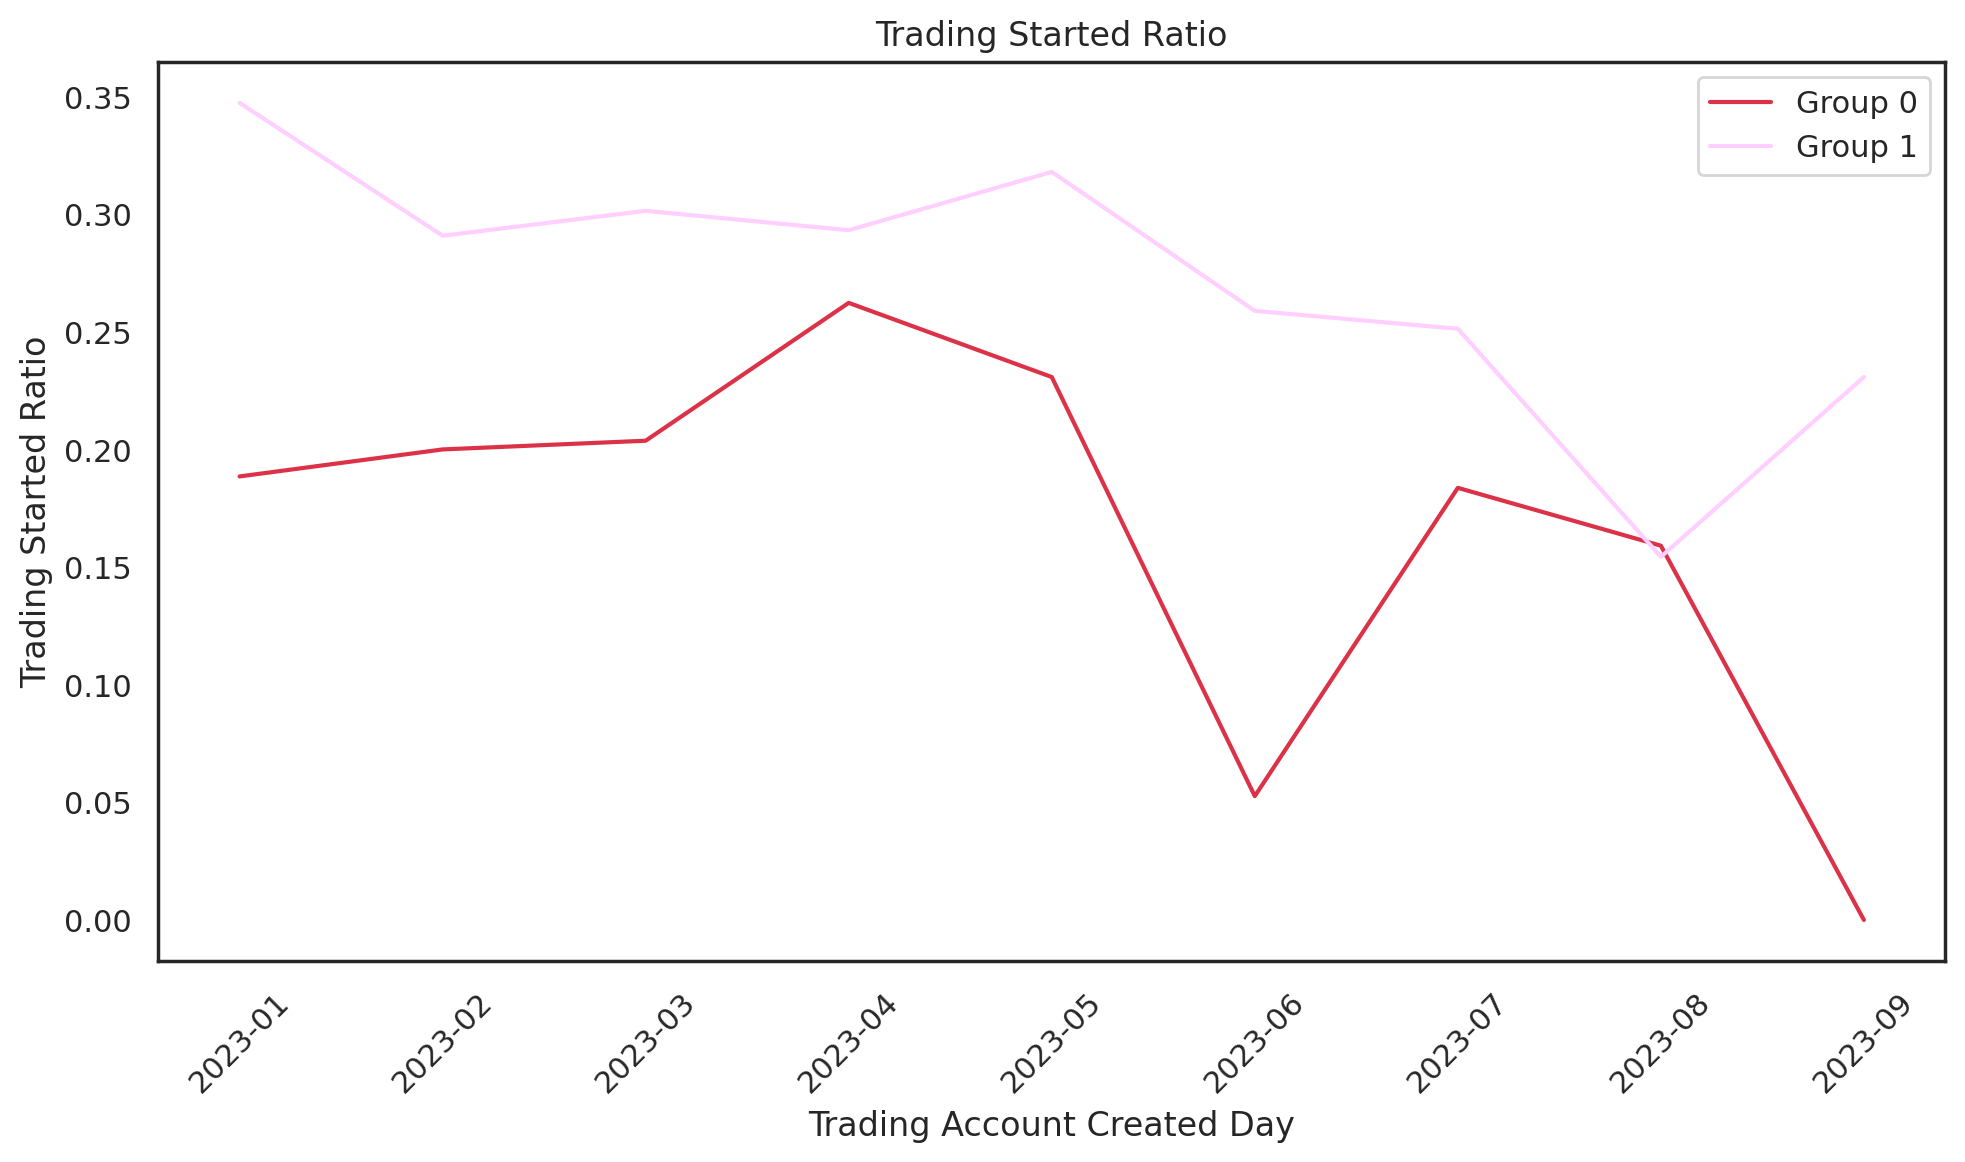

    current_group ta_created_month  total_account_created  \
0               0          2023-01                    122   
1               0          2023-02                     90   
2               0          2023-03                     54   
3               0          2023-04                     61   
4               0          2023-05                     52   
5               0          2023-06                     38   
6               0          2023-07                     49   
7               0          2023-08                     44   
8               0          2023-09                      3   
9               1          2023-01                   1958   
10              1          2023-02                    894   
11              1          2023-03                    637   
12              1          2023-04                    498   
13              1          2023-05                    412   
14              1          2023-06                    394   
15              1       

In [ ]:
df23 = df[df["trading_account_created_date"] >= "2023-01-01"]

grouped = (
    df23.groupby(["current_group", "ta_created_month"])
    .agg(
        total_account_created=("is_account_created", "sum"),
        total_trading_started=("is_trading_started", "sum"),
    )
    .reset_index()
)

grouped["trading_started_ratio"] = (
    grouped["total_trading_started"] / grouped["total_account_created"]
)

group_0 = grouped[grouped["current_group"] == 0]
group_1 = grouped[grouped["current_group"] == 1]

plt.figure(figsize=(10, 6))

plt.plot(
    group_0["ta_created_month"],
    group_0["trading_started_ratio"],
    label="Group 0",
    color=pal[1],
)
plt.plot(
    group_1["ta_created_month"],
    group_1["trading_started_ratio"],
    label="Group 1",
    color=pal[5],
)

plt.xlabel("Trading Account Created Day")
plt.ylabel("Trading Started Ratio")
plt.title("Trading Started Ratio")
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
df_test = df[
    (df["trading_account_created_date"] >= "2023-05-29")
    & (df["trading_account_created_date"] <= "2023-06-29")
]

In [ ]:
stat, pval = proportion.proportions_ztest([count_A, count_B], [nobs_A, nobs_B])
print("2-sample test for equality of proportions")
print("test statistic =", stat)
print("p-value =", round(pval, 10))

NameError: ignored